# Dashboard to look at impact tracker results for various experiment sets

## Datasets
- ukb pilot [cohort](https://github.com/neurodatascience/watts_up_compute/blob/impact_tracker/subject_lists/ukb_pilot_subjects.csv)

## Pipelines
- FreeSurfer: recon-all (1,2,3 stages)
- FastSurfer: FastSurferCNN (volumetric segmentation)

## Monitoring metrics
- experiment duration in hours
- power consumption in kWh (kilo-watt-hours) 

In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *
from experiment_impact_tracker.data_utils import (load_data_into_frame,
                                                  load_initial_info,
                                                  zip_data_and_info)

from lib.dashboard_utils import *

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=437.46 Hz, eta=0:00:00, total=0:00:01, wall=19:45 EST
Done!
../../experiment-impact-tracker/experiment_impact_tracker/data_interface.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [2]:
project_dir = '../'
fastsurfer_exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
preproc_exp_dir = '{}/preproc_pipeline_experiments/'.format(project_dir)
fastsurfer_results_dir = '{}results/exp_impact_tracker/'.format(fastsurfer_exp_dir)
preproc_results_dir = '{}results/exp_impact_tracker/'.format(preproc_exp_dir)
subject_lists = '{}subject_lists/ukb_pilot_subjects.csv'.format(project_dir)

### Custom set of trial expeirments

In [ ]:
experiment_dict = {
                   'FastSurfer_local_cpu':('{}/track_sub_000_benchmark/'.format(fastsurfer_results_dir),False), 
                   'FastSurfer_CC_cpu':('{}/CC_cpu_test/'.format(fastsurfer_results_dir),False),
                   'FastSurfer_CC_gpu':('{}/CC_gpu_test/'.format(fastsurfer_results_dir),True),
                   'autorecon1_local_test_1':('{}/ReconAll_test_local_cpu/'.format(preproc_results_dir),False),
                   'autorecon2-3_local_test_1':('{}/ReconAll_test_location_override/'.format(preproc_results_dir),False),
                   'autorecon1_CC_test_1':('{}/ReconAll_test_CC_cpu/'.format(preproc_results_dir),False),
                   'autorecon1_CC_ukb_1':('{}/ReconAll_ukb_CC_cpu/'.format(preproc_results_dir),False)
                   }

read_flops = True

power_df_concat = pd.DataFrame()
flops_df_concat = pd.DataFrame()
tracker_summary_df_concat = pd.DataFrame()

for k,v in experiment_dict.items():
    power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1], read_flops)
    power_df_concat = power_df_concat.append(power_df)
    flops_df_concat = flops_df_concat.append(flops_df)
    tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)
    


In [ ]:
exp_set = 'trial_runs'
cpu_info_df = pd.DataFrame(columns=['experiment_set','experiment_name','brand','usable_cpus'])
i = 0
for exp_name,exp_config in experiment_dict.items():
    tracker_log_dir = exp_config[0] 
    info = load_initial_info(tracker_log_dir)
    usable_cpus = info['cpu_info']['usable_cpus']
    brand = info['cpu_info']['brand_raw']
    cpu_info_df.loc[i] = [exp_set,exp_name,brand,usable_cpus]
    i = i + 1
    
cpu_info_df

In [ ]:
plot_df = tracker_summary_df_concat.copy()
plot_df['total_duration (s)'] = plot_df['total_duration_impact_tracker'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration_impact_tracker'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,3, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_name', s=100, data=plot_df, ax=ax)
    # g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_name', data=plot_df, ax=ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=50,fontsize=12)

    ax = axes[2]
    plot_df = flops_df_concat.copy()
    g = sns.scatterplot(y='power', x='DP', hue='experiment_name', style='task', s=100, data=plot_df, ax=ax)
    g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

### UKB pilot experiment sets
- recon-all 
- fastsurfer
    - pruning_{0,25,50}
    - gpu/cpu

In [3]:
save_perf = False

subject_df = pd.read_csv(subject_lists)
subject_ids = subject_df['eid']

ignore_subjects = {1009760}
subject_ids = list(set(subject_ids) - ignore_subjects)

print('Found {} subjects'.format(len(subject_ids)))

FastCNN_dir = fastsurfer_results_dir + 'ukb/FastCNN/'
FastRecon_dir = fastsurfer_results_dir + 'ukb/FastRecon/'

experiment_sets = {
                ## FreeSurfer baseline
                #    'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda

                ## FastSurferCNN run1 cpu
                #    'fastsurferCNN_run1_cpu_prune_0':(FastCNN_dir + 'run_1/cpu/prune_0/', False), # log_dir, use_cuda 
                #    'fastsurferCNN_run1_cpu_prune_25':(FastCNN_dir + 'run_1/cpu/prune_25/', False), # log_dir, use_cuda 
                #    'fastsurferCNN_run1_cpu_prune_50':(FastCNN_dir + 'run_1/cpu/prune_50/', False), # log_dir, use_cuda 
                
                ## FastSurferCNN run1 gpu
                #    'fastsurferCNN_run1_gpu_prune_0':(FastCNN_dir + 'run_1/gpu/prune_0/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run1_gpu_prune_25':(FastCNN_dir + 'run_1/gpu/prune_25/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run1_gpu_prune_50':(FastCNN_dir + 'run_1/gpu/prune_50/', True), # log_dir, use_cuda

                ## FastSurferCNN run2 cpu
                #    'fastsurferCNN_run2_cpu_prune_0':(FastCNN_dir + 'run_2/cpu/prune_0/', False), # log_dir, use_cuda 
                #    'fastsurferCNN_run2_cpu_prune_25':(FastCNN_dir + 'run_2/cpu/prune_25/', False), # log_dir, use_cuda
                #    'fastsurferCNN_run2_cpu_prune_50':(FastCNN_dir + 'run_2/cpu/prune_50/', False), # log_dir, use_cuda

                ## FastSurferCNN run2 gpu
                #    'fastsurferCNN_run2_gpu_prune_0':(FastCNN_dir + 'run_2/gpu/prune_0/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run2_gpu_prune_25':(FastCNN_dir + 'run_2/gpu/prune_25/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run2_gpu_prune_50':(FastCNN_dir + 'run_2/gpu/prune_50/', True), # log_dir, use_cuda

                ## FastSurferRecon run1 cpu
                   'fastsurferRecon_run1_cpu_prune_0':(FastRecon_dir + 'run_1/', False), # log_dir, use_cuda
                  }

for exp_set, exp_config in experiment_sets.items(): 
    print('Reading logs for: {}'.format(exp_config[0]))
    tracker_log_dir = exp_config[0]
    use_cuda = exp_config[1]
    # try:
    tracker_summary_df_concat, flops_df_concat, power_df_concat = collate_tracker_data(tracker_log_dir, subject_ids, use_cuda)
    tracker_summary_df_concat['experiment_set'] = exp_set
    flops_df_concat['experiment_set'] = exp_set
    power_df_concat['experiment_set'] = exp_set
    
    if save_perf:
        tracker_summary_df_concat.to_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
        flops_df_concat.to_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
        power_df_concat.to_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))
    # except Exception as e:
    #     print(e)
    #     continue

Found 72 subjects
Reading logs for: ..//FastSurfer_experiments/results/exp_impact_tracker/ukb/FastRecon/run_1/
../../experiment-impact-tracker/experiment_impact_tracker/data_utils.py:30: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  return json_normalize(json_array, max_level=max_level), json_array
../lib/dashboard_utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw']
../lib/dashboard_utils.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

### Collate saved tracker perf

In [6]:
tracker_summary_df_concat_exp_set = pd.DataFrame()
flops_df_concat_exp_set = pd.DataFrame()
power_df_concat_exp_set = pd.DataFrame()

experiment_sets = {
                ## FreeSurfer baseline
                   'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda

                ## FastSurferCNN run1 cpu
                   'fastsurferCNN_run1_cpu_prune_0':(FastCNN_dir + 'run_1/cpu/prune_0/', False), # log_dir, use_cuda 
                   'fastsurferCNN_run1_cpu_prune_25':(FastCNN_dir + 'run_1/cpu/prune_25/', False), # log_dir, use_cuda 
                   'fastsurferCNN_run1_cpu_prune_50':(FastCNN_dir + 'run_1/cpu/prune_50/', False), # log_dir, use_cuda 
                
                ## FastSurferCNN run1 gpu
                  #  'fastsurferCNN_run1_gpu_prune_0':(FastCNN_dir + 'run_1/gpu/prune_0/', True), # log_dir, use_cuda
                  #  'fastsurferCNN_run1_gpu_prune_25':(FastCNN_dir + 'run_1/gpu/prune_25/', True), # log_dir, use_cuda
                  #  'fastsurferCNN_run1_gpu_prune_50':(FastCNN_dir + 'run_1/gpu/prune_50/', True), # log_dir, use_cuda

                ## FastSurferCNN run2 cpu
                #    'fastsurferCNN_run2_cpu_prune_0':(FastCNN_dir + 'run_2/cpu/prune_0/', False), # log_dir, use_cuda 
                #    'fastsurferCNN_run2_cpu_prune_25':(FastCNN_dir + 'run_2/cpu/prune_25/', False), # log_dir, use_cuda
                #    'fastsurferCNN_run2_cpu_prune_50':(FastCNN_dir + 'run_2/cpu/prune_50/', False), # log_dir, use_cuda

                ## FastSurferCNN run2 gpu
                   'fastsurferCNN_run2_gpu_prune_0':(FastCNN_dir + 'run_2/gpu/prune_0/', True), # log_dir, use_cuda
                   'fastsurferCNN_run2_gpu_prune_25':(FastCNN_dir + 'run_2/gpu/prune_25/', True), # log_dir, use_cuda
                   'fastsurferCNN_run2_gpu_prune_50':(FastCNN_dir + 'run_2/gpu/prune_50/', True), # log_dir, use_cuda

                ## FastSurferRecon run1 cpu
                   'fastsurferRecon_run1_cpu_prune_0':(FastRecon_dir + 'run_1/', False), # log_dir, use_cuda
                  }

for exp_set, exp_config in experiment_sets.items(): 

   tracker_log_dir = exp_config[0]
   
   try:
      tracker_summary_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
      flops_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
      power_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))

      tracker_summary_df_concat_exp_set = tracker_summary_df_concat_exp_set.append(tracker_summary_df_concat)
      flops_df_concat_exp_set = flops_df_concat_exp_set.append(flops_df_concat)
      power_df_concat_exp_set = power_df_concat_exp_set.append(power_df_concat)

   except Exception as e:
        print(e)
        continue

### Grab CPU/GPU info from the tracker logs

In [7]:
exp_names = tracker_summary_df_concat['experiment_name'].values

cpu_info_df = pd.DataFrame(columns=['experiment_set','experiment_name','brand','usable_cpus'])

i = 0
for exp_set, exp_config in experiment_sets.items(): 
    for exp_name in exp_names:
        tracker_log_dir = exp_config[0] + '/sub-{}'.format(int(exp_name))
        info = load_initial_info(tracker_log_dir)
        usable_cpus = info['cpu_info']['usable_cpus']
        brand = info['cpu_info']['brand_raw']
        cpu_info_df.loc[i] = [exp_set,exp_name,brand,usable_cpus]
        i = i + 1

# example run info across experiment sets
cpu_info_df[cpu_info_df['experiment_name']==1047553]

,experiment_set,experiment_name,brand,usable_cpus
0,recon-all,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1
72,fastsurferCNN_run1_cpu_prune_0,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8
144,fastsurferCNN_run1_cpu_prune_25,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8
216,fastsurferCNN_run1_cpu_prune_50,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8
288,fastsurferCNN_run2_gpu_prune_0,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,16
360,fastsurferCNN_run2_gpu_prune_25,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,16
432,fastsurferCNN_run2_gpu_prune_50,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,16
504,fastsurferRecon_run1_cpu_prune_0,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1


## Plots
### Duration

### Total power usage per experiment (i.e. subject)

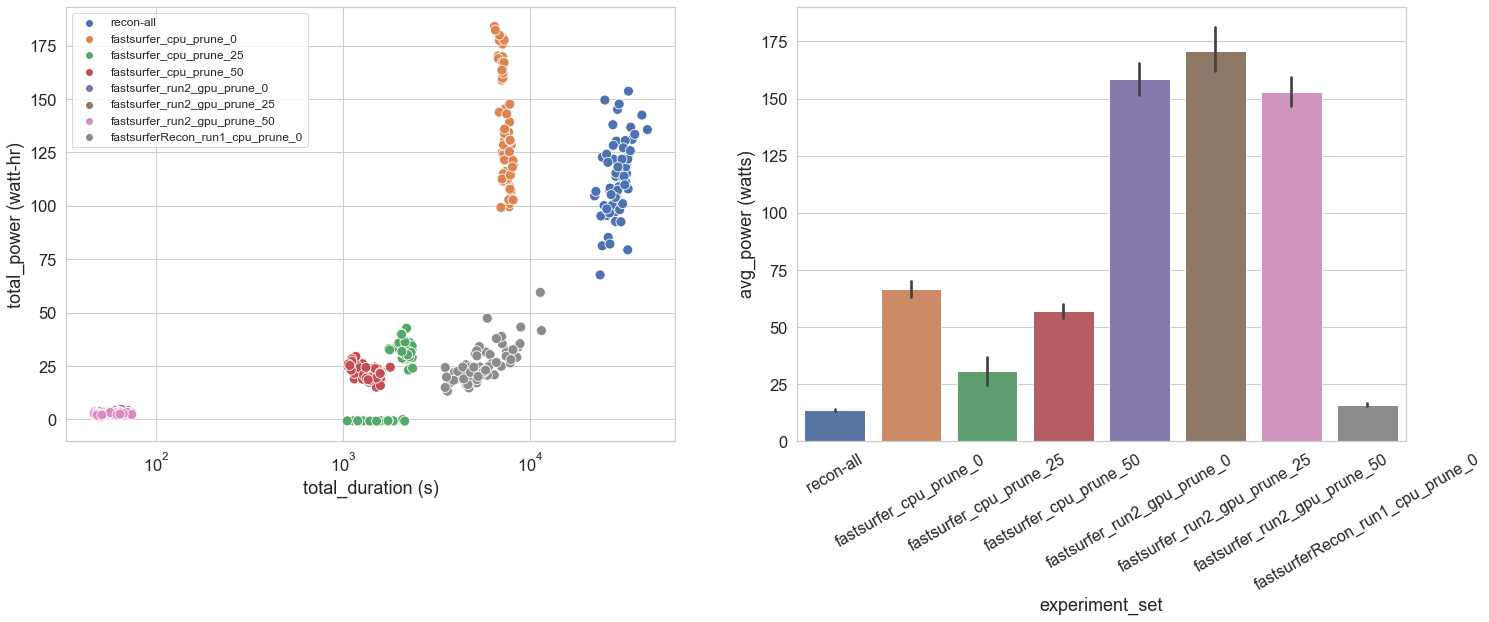

In [8]:
plot_df = tracker_summary_df_concat_exp_set.copy()
plot_df['total_duration (s)'] = plot_df['total_duration_impact_tracker'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration_impact_tracker'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,2, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_set', s=100, data=plot_df, ax=ax)
    # g = sns.barplot(y='total_power (watt-hr)', x='experiment_set',  data=plot_df, ax=ax)
    g.set(xscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_set', data=plot_df, ax=ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=30,fontsize=16)
    # g.set(yscale='log') 



### Power for segmentation

2453 2381
577


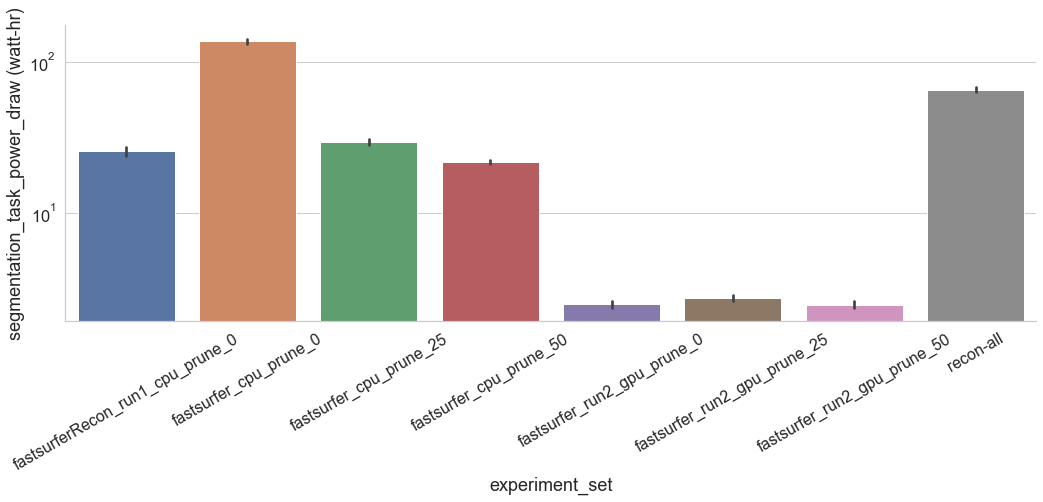

In [9]:
flops_df_concat_exp_set_segmentation = flops_df_concat_exp_set.copy()
flops_df_concat_exp_set_segmentation = flops_df_concat_exp_set_segmentation[~flops_df_concat_exp_set_segmentation['task'].isin(['autorecon3'])]
print(len(flops_df_concat_exp_set),len(flops_df_concat_exp_set_segmentation))
flops_df_concat_exp_set_segmentation = flops_df_concat_exp_set_segmentation.groupby(['experiment_name','experiment_set']).sum().reset_index()
print(len(flops_df_concat_exp_set_segmentation))
plot_df = flops_df_concat_exp_set_segmentation.copy()
plot_df['segmentation_task_power_draw (watt-hr)'] = plot_df['power']*1000

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='segmentation_task_power_draw (watt-hr)', x='experiment_set', data=plot_df, kind='bar',aspect=3)
    g.set(yscale='log')
    g.set_xticklabels(rotation=30,fontsize=16)



### avg power reading

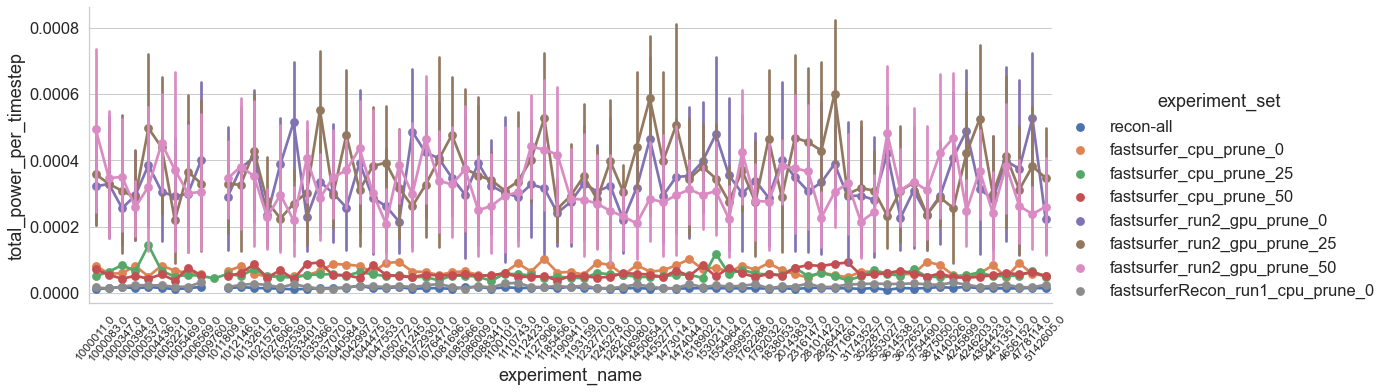

In [10]:
plot_df = power_df_concat_exp_set.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='total_power_per_timestep', x='experiment_name', hue='experiment_set', data=plot_df, kind='point',aspect=3)
    g.set_xticklabels(rotation=50,fontsize=12)


### Flops vs Power

In [ ]:
plot_df = flops_df_concat_exp_set.copy()
plot_df = plot_df[~(plot_df['experiment_set']=='recon-all')]
plot_df['power'] = plot_df['power']*1000000
sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,10),sharex=False,sharey=False)
    g = sns.scatterplot(y='power', x='DP', hue='experiment_set', alpha=0.5, style='task', s=200, data=plot_df)
    # g = sns.scatterplot(y='power', x='DP', hue='task', s=100, data=plot_df)
    g.set(xscale='log',yscale='log',ylim=[1, 1000000]) 


### Power trace

In [ ]:
experiment_set =  'recon-all' #'recon-all' #'fastsurfer_gpu_prune_0'
experiment_name = 1474044
use_cuda = True
plot_epochs = False

plot_df = power_df_concat_exp_set[(power_df_concat_exp_set['experiment_set']==experiment_set) & (power_df_concat_exp_set['experiment_name']==experiment_name)].copy()
total_power = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['total_power'].values[0]
PUE = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['PUE'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(plot_df['timestamp'],plot_df['total_power_per_timestep'].cumsum(),label='total attributed_power')

    if plot_epochs: 
        for e in epochs:
            g = plt.axvline(e, linestyle='-',c='purple')
        
    g = plt.axhline(total_power, linestyle='--',c='black',label='total power estimate')
    
    plt.ylabel('power_draws')
    plt.legend()
